# Лабораторная 4
Тема: Итерационные методы решения СЛАУ  
Для реализации выбраны методы Якоби и метод скорейшего спуска  
Вариант 1

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib

Реализация метода Якоби  
$A\overrightarrow{x} = \overrightarrow{b}
$  
$\overrightarrow{x} = B\overrightarrow{x} + \overrightarrow{g}$.

B и $\overrightarrow{g}$ таковы, что  
 $b_{ii}=0, b_{ij}=-\frac{a_{ij}}{a_{ii}}, g_i=\frac{b_i}{a_{ii}}$

 $x^i_{k+1} = -(\sum_{j=1}^{i-1}b_{ij}x^j_k + \sum_{j=i+1}^{n}b_{ij}x^j_k) + g_i$    
$\overrightarrow{x}_{k+1} = B\overrightarrow{x}_{k} + \overrightarrow{g}$

In [167]:
def jacobi(A, b, eps):
    n, m = A.shape
    assert n == m, "The matrix is not square"

    B = np.zeros((n, m))
    g = np.zeros(n)

    for i in range(n):
        assert A[i][i], "A[i][i] = 0. Algorithm can't proceed"
        for j in range(m):
            if i == j:
                continue
            B[i][j] = -A[i][j] / A[i][i]
        g[i] = b[i] / A[i][i]

    B_norm = np.linalg.norm(B)
    assert B_norm < 1, "B_norm > 1. Algorithm can't proceed"

    x_prev = -g
    x_cur = g

    losses = np.empty(shape=1, dtype=np.float64)
    while B_norm * np.linalg.norm(x_cur - x_prev) / (1 - B_norm) >= eps:
        losses = np.append(losses, np.linalg.norm(A @ x_cur - b)) # Норма вектора невязки
        x_prev = x_cur
        x_cur = B @ x_prev + g

    return (x_cur, losses)

Реализация метода наискорейшего спуска
$A\overrightarrow{x} = \overrightarrow{b}$  
$\overrightarrow{x}_{k+1} = \overrightarrow{x}_k - \tau_{k+1}\overrightarrow{r}_k$, где  
$\overrightarrow{r}_k = A\overrightarrow{x}_k-\overrightarrow{b}$  
$\tau_{k+1}=\frac{\left( \overrightarrow{r_k}, \overrightarrow{r_k} \right)}{\left( A\overrightarrow{r_k}, \overrightarrow{r_k} \right)}$


In [162]:
def boosting(A, b, eps):
    n, m = A.shape
    assert n == m, "The matrix is not square"

    x_prev = -b
    x_cur = b

    losses = np.empty(shape=1, dtype=np.float64)
    while np.linalg.norm(x_cur - x_prev) >= eps:
        losses = np.append(losses, np.linalg.norm(A @ x_cur - b)) # Норма вектора невязки
        x_prev = x_cur
        r = A @ x_prev - b
        tau = r * r / ((A @ r) * r)
        x_cur = x_prev - tau * r

    return (x_cur, losses)

In [188]:
filepath = "data.txt"
path = pathlib.Path(filepath)
assert path.exists(), f"No file found at {path.absolute()}"
A1 = np.loadtxt(path, max_rows=3, dtype=np.float64)
A2 = np.loadtxt(path, skiprows=3, dtype=np.float64)

In [189]:
def get_sle(A):
    n, m = A.shape
    assert n == m, "The matrix is not square"
    x = np.ones(n)
    b = A @ x
    return x, b

x1, b1 = get_sle(A1)
x2, b2 = get_sle(A2)

Сначала решим первую СЛУ обоими методами

In [190]:
eps = 10 ** -9
x_jacobi, losses_jacobi = jacobi(A1, b1, eps)
x_boosting, losses_boosting = boosting(A1, b1, eps)

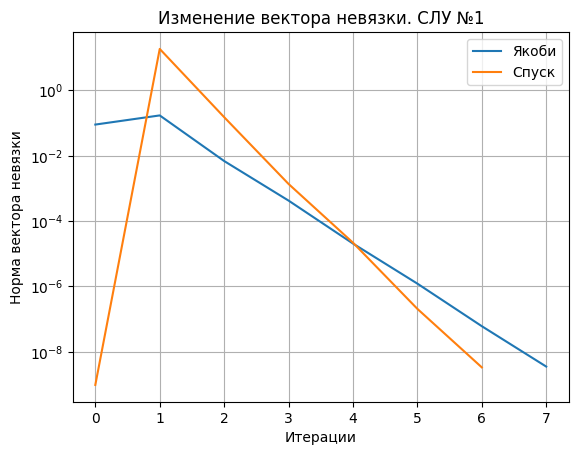

In [191]:
fig, ax = plt.subplots()
ax.plot(losses_jacobi, label="Якоби")
ax.plot(losses_boosting, label="Спуск")
ax.set_yscale('log')
ax.set_title("Изменение вектора невязки. СЛУ №1")
ax.set_xlabel("Итерации")
ax.set_ylabel("Норма вектора невязки")
ax.legend()
ax.grid(True)

Решим вторую СЛУ обоими методами.
Заметим, что метод Якоби не сходится в силу величины матрицы B
Метод скорейшего спуска так же не сходится, т.к. матрица A должна быть положительно определена

In [192]:
eps = 10 ** -1
x_jacobi, losses_jacobi = jacobi(A2, b2, eps)
x_boosting, losses_boosting = boosting(A2, b2, eps)

AssertionError: B_norm > 1. Algorithm can't proceed

Построим для первой матрицы, матрицы 3 порядка, следующую СЛУ:  
$A^TA\overrightarrow{x}=A^T\overrightarrow{b}$  
Решим её двумя методами

In [193]:
def get_sle_transpose(A, b):
    A_new = A.transpose() @ A
    b_new = A.transpose() @ b
    return A_new, b_new

A, b = get_sle_transpose(A1, b1)
x = x1

In [194]:
eps = 10 ** -9
x_jacobi, losses_jacobi = jacobi(A, b, eps)
x_boosting, losses_boosting = boosting(A, b, eps)

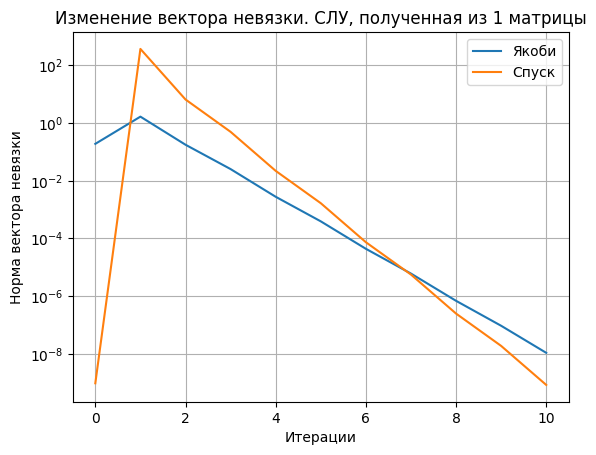

In [195]:
fig, ax = plt.subplots()
ax.plot(losses_jacobi, label="Якоби")
ax.plot(losses_boosting, label="Спуск")
ax.set_yscale('log')
ax.set_title("Изменение вектора невязки. СЛУ, полученная из 1 матрицы")
ax.set_xlabel("Итерации")
ax.set_ylabel("Норма вектора невязки")
ax.legend()
ax.grid(True)

In [196]:
r_jacobi = A @ x_jacobi - b
r_boosting = A @ x_boosting - b
print(f"""Метод Якоби:\n
    \tКоличество итераций {losses_jacobi.size}\n
    \tВектор невязки {r_jacobi}\n
    \tПогрешность {eps}\n
    \tРешение {x_jacobi}""")
print(f"""Метод Якоби:\n
    \tКоличество итераций {losses_boosting.size}\n
    \tВектор невязки {r_boosting}\n
    \tПогрешность {eps}\n
    \tРешение {x_boosting}""")

Метод Якоби:

    	Количество итераций 11

    	Вектор невязки [ 1.10473763e-09  7.34257100e-10 -7.49503570e-10]

    	Погрешность 1e-09

    	Решение [1. 1. 1.]
Метод Якоби:

    	Количество итераций 11

    	Вектор невязки [-4.63131755e-11 -3.73194808e-11  3.03135295e-11]

    	Погрешность 1e-09

    	Решение [1. 1. 1.]
